# Sentence Transformer 來做 Triplet 的分類任務 (Positive / Negative)
任務說明:
給定一段句子與 triplet，判斷 triplet 是否為 positive 或是 negative
1. Positive (0) 定義 : 與 distractor 相關的 triplet<br>
2. Negative (1) 定義 : 與 distractor 不相關的 triplet<br>

### GPU

In [1]:
!nvidia-smi

Thu Sep  7 07:08:35 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX                On | 00000000:01:00.0 Off |                  N/A |
| 41%   40C    P8               19W / 280W|      1MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Weight and Bias (Assisting Metrics, Optional)

In [2]:
project_name = "test Sentence Transformer reranker on Sciq"
import os

os.environ["WANDB_PROJECT"] = project_name

### Import

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch

2023-09-07 07:08:35.976008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 07:08:36.082494: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-07 07:08:36.549053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2023-09-07 07:08:36.549169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or direc

## Prepare Data

In [4]:
import json
import os, sys
import fnmatch

In [11]:
def read_data(item):
    path = '../../../../data/sciq/{}.with.triplet.json'.format(item)
    with open(path) as f:
        data = json.load(f)
    return data

In [12]:
train = read_data('train')
valid = read_data('valid')
test = read_data('test')

In [13]:
len(train), len(valid), len(test)

(11679, 1000, 1000)

In [14]:
train[0]

{'sentence': 'What type of organism is commonly used in preparation of foods such as cheese and yogurt?',
 'distractors': ['protozoa', 'gymnosperms', 'viruses'],
 'answer': 'mesophilic organisms',
 'triplets': [['isa', 'yogurt', 'food', 0.5036563873291016],
  ['relatedto', 'cheese', 'yogurt', 0.5036563873291016],
  ['relatedto', 'organisms', 'organism', 0.48464348912239075],
  ['antonym', 'thermophilic', 'psychrophilic', 0.3640008568763733],
  ['isa', 'cheese', 'food', 0.33733850717544556],
  ['relatedto', 'preparation', 'food', 0.33733850717544556],
  ['relatedto', 'cheese', 'food', 0.33733850717544556],
  ['relatedto', 'foods', 'food', 0.33733850717544556],
  ['relatedto', 'food', 'foods', 0.33733850717544556],
  ['antonym', 'anaerobic', 'aerobic', 0.28718218207359314],
  ['antonym', 'aerobic', 'anaerobic', 0.28718218207359314],
  ['relatedto', 'anaerobic', 'organism', 0.28718218207359314],
  ['relatedto', 'used', 'use', 0.14599347114562988]]}

In [9]:
# Initial Triplet with Sentence Transformer
print(test[0]['sentence'])
print(test[0]['distractors'])
print(test[0]['answer'])
test[0]['triplets'][:10]

Compounds that are capable of accepting electrons, such as o 2 or f2, are called what?
['antioxidants', 'Oxygen', 'residues']
oxidants


[['relatedto', 'oxidants', 'oxidant', 0.6359457969665527],
 ['relatedto', 'electrons', 'electron', 0.46036529541015625],
 ['relatedto', 'delocalized', 'electron', 0.43334996700286865],
 ['relatedto', 'redox', 'electron', 0.43334996700286865],
 ['relatedto', 'proton', 'electron', 0.43334996700286865],
 ['relatedto', 'electron', 'proton', 0.43334996700286865],
 ['relatedto', 'delocalized', 'compound', 0.32832592725753784],
 ['relatedto', 'called', 'call', -0.034704722464084625]]

Relation Dictionary

In [10]:
Relation_Dict ={
 'antonym': 'is the antonym of',
 'atlocation' : 'is at location of',
 'capableof': 'is capable of',
 'causes' : 'causes',
 'createdby': 'is created by',
 'desires': 'desires',
 'hasproperty': 'has property',
 'hassubevent': 'has subevent',
 'isa':'is a kind of',
 'madeof':'is made of',
 'notcapableof':'has not capable of',
 'notdesires': "does not desires",
 'partof':'is part of',
 'receivesaction':'is',
 'relatedto':'is related to',
 'usedfor':'is used for'
}

In [11]:
def processData(data):
    
    sentences = []
    triplets = []
    labels = []
    answers = []
    for d in data:

        sentence = d['sentence']
        distractors = d['distractors']
        answer = d['answer']
        triplet = d['triplets']


        distractors = [dis.strip() for dis in distractors]
        sentence = sentence + ' ' +answer

        
        for each_triplet in triplet:
            rel, source, target, weight = each_triplet

            sentences.append(sentence)
            triplets.append('{} {} {}'.format(source,Relation_Dict[rel],target))

            if source == answer or target == answer or source in distractors or target in distractors:
                labels.append(0)
            else:
                labels.append(1)
            
              
        
    return sentences, triplets, labels

In [12]:
train_sent, train_triplet, train_label = processData(train)
valid_sent, valid_triplet, valid_label = processData(valid)
test_sent, test_triplet, test_label = processData(test)

In [13]:
len(train_sent), len(valid_sent), len(test_sent)

(260474, 22596, 22403)

統計訓練與測試資料分布

In [14]:
print('Train 資料分布 : Positive 有 {} 筆, Negative 有 {} 筆，大約有 {:.2f}% 為 Positive。'.format(train_label.count(0),train_label.count(1),train_label.count(0)/len(train_sent)*100))
print('Valid 資料分布 : Positive 有 {} 筆, Negative 有 {} 筆，大約有 {:.2f}% 為 Positive。'.format(valid_label.count(0),valid_label.count(1),valid_label.count(0)/len(valid_sent)*100))
print('Test 資料分布 : Positive 有 {} 筆, Negative 有 {} 筆，大約有 {:.2f}% 為 Positive。'.format(test_label.count(0),test_label.count(1),test_label.count(0)/len(test_sent)*100))

Train 資料分布 : Positive 有 39688 筆, Negative 有 220786 筆，大約有 15.24% 為 Positive。
Valid 資料分布 : Positive 有 3147 筆, Negative 有 19449 筆，大約有 13.93% 為 Positive。
Test 資料分布 : Positive 有 3499 筆, Negative 有 18904 筆，大約有 15.62% 為 Positive。


## Tokenization

In [15]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

In [16]:
train_encodings = tokenizer(train_sent, train_triplet, truncation=True, padding=True)
valid_encodings = tokenizer(valid_sent, valid_triplet, truncation=True, padding=True)
test_encodings = tokenizer(test_sent, test_triplet, truncation=True, padding=True)

In [17]:
print(train_encodings['input_ids'][0])
print(tokenizer.decode(train_encodings['input_ids'][0]))

[0, 2058, 2832, 2001, 15927, 2007, 4145, 2113, 2003, 7551, 2001, 9444, 2111, 2008, 8812, 2002, 10934, 27394, 2106, 1033, 2037, 28797, 19470, 2598, 11771, 2, 2, 10934, 27394, 2106, 2007, 1041, 2789, 2001, 2837, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<s> what type of organism is commonly used in preparation of foods such as cheese and yogurt? mesophilic organisms </s> </s> yogurt is a kind of food </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

In [18]:
def add_labels(encodings, label):
    encodings.update({'labels': label})

In [19]:
add_labels(train_encodings, train_label)
add_labels(valid_encodings, valid_label)
add_labels(test_encodings, test_label)

In [43]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [44]:
print(train_encodings['labels'][0])

1


## 定義 Dataset，並轉換成 tensor 格式

In [20]:
from torch.utils import data
import torch

class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings.input_ids)

train_dataset = Dataset(train_encodings)
valid_dataset = Dataset(valid_encodings)
test_dataset = Dataset(test_encodings)

In [21]:
train_dataset[0]

{'input_ids': tensor([    0,  2058,  2832,  2001, 15927,  2007,  4145,  2113,  2003,  7551,
          2001,  9444,  2111,  2008,  8812,  2002, 10934, 27394,  2106,  1033,
          2037, 28797, 19470,  2598, 11771,     2,     2, 10934, 27394,  2106,
          2007,  1041,  2789,  2001,  2837,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1]),
 'atten

## Fine-Tuning

### Load Sentence-Transformers model from HuggingFace Hub

In [22]:
from transformers import MPNetConfig, MPNetForSequenceClassification
config  = MPNetConfig.from_pretrained('sentence-transformers/all-mpnet-base-v2', num_labels = 2) # num_labels 設定類別數
model = MPNetForSequenceClassification.from_pretrained('sentence-transformers/all-mpnet-base-v2', config=config)

Some weights of the model checkpoint at sentence-transformers/all-mpnet-base-v2 were not used when initializing MPNetForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a

查看模型架構

In [23]:
print(model)

MPNetForSequenceClassification(
  (mpnet): MPNetModel(
    (embeddings): MPNetEmbeddings(
      (word_embeddings): Embedding(30527, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): MPNetEncoder(
      (layer): ModuleList(
        (0): MPNetLayer(
          (attention): MPNetAttention(
            (attn): MPNetSelfAttention(
              (q): Linear(in_features=768, out_features=768, bias=True)
              (k): Linear(in_features=768, out_features=768, bias=True)
              (v): Linear(in_features=768, out_features=768, bias=True)
              (o): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [24]:
from transformers import TrainingArguments, Trainer

In [25]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
   
    results = metric.compute(predictions=predictions, references=labels)

    return {'accuracy': results['accuracy']}

In [27]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [28]:
batch_size = 32
args = TrainingArguments(
    output_dir = "./results",
    save_strategy = "epoch",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    eval_accumulation_steps = 1,
    report_to="wandb" if os.getenv("WANDB_PROJECT") else "none"
)

In [29]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [30]:
trainer.train()

/user_data/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 260474
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 40700
  Number of trainable parameters = 109488002
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hankystyle. Use `wandb login --relogin` to force relogin


You're using a MPNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/user_data/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.115300,0.149352,0.950478
2,0.083100,0.192110,0.938042
3,0.064700,0.219127,0.944902
4,0.049400,0.270437,0.942246
5,0.039900,0.282756,0.942999
6,0.032400,0.386671,0.940742
7,0.025800,0.406145,0.932820
8,0.021000,0.367543,0.939016
9,0.014700,0.411724,0.939547
10,0.011900,0.440460,0.938440


***** Running Evaluation *****
  Num examples = 22596
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-4070
Configuration saved in ./results/checkpoint-4070/config.json
Model weights saved in ./results/checkpoint-4070/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-4070/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-4070/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-5416] due to args.save_total_limit
/user_data/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 22596
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-8140
Configuration saved in ./results/checkpoint-8140/config.json
Model weights saved in ./results/checkpoin

TrainOutput(global_step=40700, training_loss=0.050386017587319636, metrics={'train_runtime': 12746.8325, 'train_samples_per_second': 204.344, 'train_steps_per_second': 3.193, 'total_flos': 1.6464123928051555e+17, 'train_loss': 0.050386017587319636, 'epoch': 10.0})

In [56]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 22554
  Batch size = 64
/user_data/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.15615184605121613,
 'eval_accuracy': 0.9524252904141173,
 'eval_runtime': 26.965,
 'eval_samples_per_second': 836.417,
 'eval_steps_per_second': 13.091,
 'epoch': 10.0}

In [31]:
predictions, labels, metrics = trainer.predict(test_dataset)
print('test: ')
metrics

***** Running Prediction *****
  Num examples = 22403
  Batch size = 64
/user_data/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


test: 


{'test_loss': 0.1710093915462494,
 'test_accuracy': 0.9469267508815784,
 'test_runtime': 22.0051,
 'test_samples_per_second': 1018.083,
 'test_steps_per_second': 15.951}

In [32]:
trainer.save_model('./saved_models/sentence-transformer-sciq-all')

Saving model checkpoint to ./saved_models/sentence-transformer-sciq-all
Configuration saved in ./saved_models/sentence-transformer-sciq-all/config.json
Model weights saved in ./saved_models/sentence-transformer-sciq-all/pytorch_model.bin
tokenizer config file saved in ./saved_models/sentence-transformer-sciq-all/tokenizer_config.json
Special tokens file saved in ./saved_models/sentence-transformer-sciq-all/special_tokens_map.json


## Inference


In [33]:
sentence = test_sent[0]
triplet = test_triplet[0]
print('sentence = ',sentence)
print('triplet = ',triplet)

sentence =  Compounds that are capable of accepting electrons, such as o 2 or f2, are called what? oxidants
triplet =  oxidants is related to oxidant


In [34]:
from transformers import MPNetConfig, MPNetForSequenceClassification
config  = MPNetConfig.from_pretrained('./saved_models/sentence-transformer-sciq-all', num_labels = 2)
model = MPNetForSequenceClassification.from_pretrained('./saved_models/sentence-transformer-sciq-all', config=config)

loading configuration file ./saved_models/sentence-transformer-sciq-all/config.json
Model config MPNetConfig {
  "_name_or_path": "sentence-transformers/all-mpnet-base-v2",
  "architectures": [
    "MPNetForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "problem_type": "single_label_classification",
  "relative_attention_num_buckets": 32,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30527
}

loading weights file ./saved_models/sentence-transformer-sciq-all/pytorch_model.bin


All model checkpoint weights were used when initializing MPNetForSequenceClassification.

All the weights of MPNetForSequenceClassification were initialized from the model checkpoint at ./saved_models/sentence-transformer-sciq-all.
If your task is similar to the task the model of the checkpoint was trained on, you can already use MPNetForSequenceClassification for predictions without further training.


In [35]:
input_encodings = tokenizer([sentence], [triplet], truncation=True, padding=True)

In [36]:
input_dataset = Dataset(input_encodings)

In [37]:
input_dataset[0]

{'input_ids': tensor([    0, 10103,  2012,  2028,  5218,  2001, 10568, 15061,  1014,  2111,
          2008,  1055,  1020,  2034,  1046,  2479,  1014,  2028,  2174,  2058,
          1033, 23064,  8528,  7670,     2,     2, 23064,  8528,  7670,  2007,
          3145,  2004, 23064,  8528,  3376,     2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

## Validation 分布情況

In [38]:
predictions, labels, metrics = trainer.predict(valid_dataset)
print('valid: ')
metrics

***** Running Prediction *****
  Num examples = 22596
  Batch size = 64
/user_data/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


valid: 


{'test_loss': 0.14935167133808136,
 'test_accuracy': 0.950477960701009,
 'test_runtime': 21.7443,
 'test_samples_per_second': 1039.171,
 'test_steps_per_second': 16.28}

In [39]:
predictions = np.argmax(predictions, axis=-1)

In [40]:
from datasets import load_metric
accuracy_metric = load_metric("accuracy")

accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
print('accuracy : ', accuracy)

/tmp/ipykernel_6427/2714362684.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


accuracy :  {'accuracy': 0.950477960701009}


In [41]:
from sklearn.metrics import classification_report

for line in classification_report(labels, predictions).split('\n'):
  print(line)

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      3147
           1       0.96      0.98      0.97     19449

    accuracy                           0.95     22596
   macro avg       0.91      0.88      0.89     22596
weighted avg       0.95      0.95      0.95     22596



In [42]:
# **產生 confusion matrix heatmap **
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
cf_matrix = confusion_matrix(labels, predictions)
print(cf_matrix)

[[ 2454   693]
 [  426 19023]]


In [43]:
matthews = matthews_corrcoef(labels, predictions)
print(matthews)

0.7868568412643547


### HeatMap

<Axes: xlabel='Predicted', ylabel='True Label'>

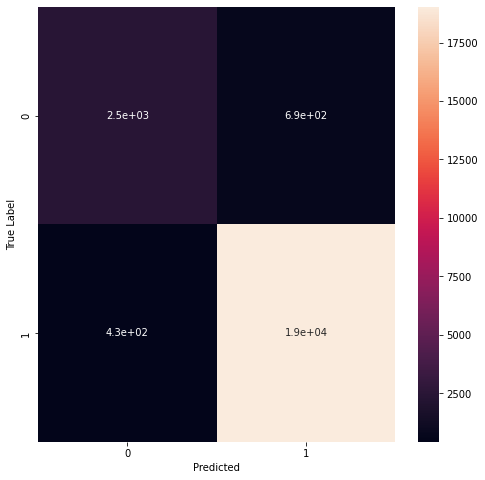

In [44]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

col = [ i for i in range(0,2)] #類別名稱

df_cm = pd.DataFrame(cf_matrix, columns=col, index = col)
df_cm.index.name = 'True Label'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)

## Testing 分布情況 

In [45]:
predictions, labels, metrics = trainer.predict(test_dataset)
print('test: ')
metrics

***** Running Prediction *****
  Num examples = 22403
  Batch size = 64
/user_data/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


test: 


{'test_loss': 0.1710093915462494,
 'test_accuracy': 0.9469267508815784,
 'test_runtime': 22.1427,
 'test_samples_per_second': 1011.753,
 'test_steps_per_second': 15.852}

In [46]:
predictions = np.argmax(predictions, axis=-1)

In [47]:
from datasets import load_metric
accuracy_metric = load_metric("accuracy")

accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
print('accuracy : ', accuracy)

accuracy :  {'accuracy': 0.9469267508815784}


In [48]:
from sklearn.metrics import classification_report

for line in classification_report(labels, predictions).split('\n'):
  print(line)

              precision    recall  f1-score   support

           0       0.89      0.75      0.82      3499
           1       0.95      0.98      0.97     18904

    accuracy                           0.95     22403
   macro avg       0.92      0.87      0.89     22403
weighted avg       0.95      0.95      0.94     22403



In [49]:
# **產生 confusion matrix heatmap **
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
cf_matrix = confusion_matrix(labels, predictions)
print(cf_matrix)

[[ 2621   878]
 [  311 18593]]


In [50]:
matthews = matthews_corrcoef(labels, predictions)
print(matthews)

0.7885899871593122


<Axes: xlabel='Predicted', ylabel='True Label'>

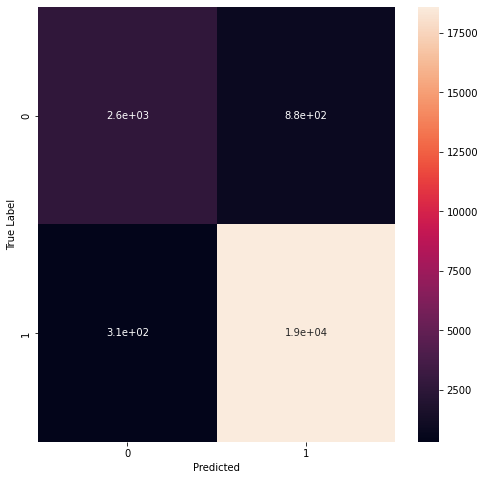

In [51]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

col = [ i for i in range(0,2)] #類別名稱

df_cm = pd.DataFrame(cf_matrix, columns=col, index = col)
df_cm.index.name = 'True Label'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)